# Dataloaders

In [1]:
# Importing libraries
import torchio as tio
import glob
import numpy as np
import random
import os
import pickle

from collections import OrderedDict
from pathlib import Path

from tqdm import tqdm
import time

import torchio as tio
from torchio.transforms import (RescaleIntensity,RandomFlip,Compose, HistogramStandardization)

from sklearn.metrics import accuracy_score

from torch.utils.data import DataLoader
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

In [17]:
with open('../2_AE_training/study_test_design.pkl', 'rb') as f:
    design = pickle.load(f)

In [18]:
# List IDs of all participants with albinism
ids_albinism=['Nyst01','Nyst02','Nyst03','Nyst04','Nyst05','Nyst06','Nyst07','Nyst08','Nyst09',
              'Nyst10','Nyst11','Nyst12','Nyst13','Nyst16','Nyst20','Nyst21','Nyst24', 'Nyst25',
              'Nyst31','Nyst35','Nyst37','Nyst43','Nyst45','ALB1','ALB2','ALB3','ALB4',
              'ALB5','ALB6','ALB7','ALB8','ALB9'] 

In [19]:
study_design = {}

study_design['train']={}
study_design['dev_train']={}
study_design['dev_test']={}
study_design['test_1']={}
study_design['test_2']={}

In [20]:
# Asign CHIASM participants to groups
subjects=[]
control=[]
albinism=[]
achiasma=[]
hypoplasia=[]

# List of subjects
for group in design.keys():
    for dataset in design[group].keys():
        
        if dataset == 'CHIASM':
            subjects+=(list(design[group][dataset].keys())[:])

# Asign them to 4 distinct groups
for sub in subjects:
    if sub in ids_albinism:
        albinism.append(sub)
    elif sub == 'CHP1':
        hypoplasia.append(sub)
    elif sub == 'ACH1':
        achiasma.append(sub)
    else:
        control.append(sub)
        
# Copy entries of chosen subjects to dictionary
random.shuffle(albinism)
random.shuffle(control)

classes=['control','albinism','achiasma','hypoplasia']
classes_indices=[0,1,2,2]
sampling_per_category = [[2,5,1,0],[2,6,1,0],[0,0,1,0],[0,1,0,0]]
categories=['dev_test','test_1','test_2']

for i in range(len(categories)):
    
    study_design[categories[i]]['CHIASM']={}
    
    for j in range(len(classes)):
        
        study_design[categories[i]]['CHIASM'][classes[j]]={}
        
        for k in range(sum(sampling_per_category[j][:i]),sum(sampling_per_category[j][:(i+1)])):
            
            study_design[categories[i]]['CHIASM'][classes[j]][eval(classes[j])[k]] = {
            'chiasm':'../../1_Data/1_Input/CHIASM/'+eval(classes[j])[k]+'/chiasm.nii.gz',
            'chiasm_resampled':'../../1_Data/1_Input/CHIASM/'+eval(classes[j])[k]+'/chiasm_sampling.nii.gz',
            'class':classes_indices[j]} 

In [21]:
# Asign UoN participants
subjects=[]
control=[]
albinism=[]

# List of subjects
for group in design.keys():
    for dataset in design[group].keys():
        
        if dataset == 'UoN':
            subjects+=(list(design[group][dataset].keys())[:])

# Asign them to 2 distinct groups
for sub in subjects:
    if sub in ids_albinism:
        albinism.append(sub)
    else:
        control.append(sub)
        
random.shuffle(control)
random.shuffle(albinism)
        
# Copy entries to dictionary
classes=['control','albinism']
classes_indices=[0,1]
sampling_per_category = [[18,2],[18,5]]
categories=['train','dev_train']

# Controls
for i in range(len(categories)):
    study_design[categories[i]]['UoN']={}
    
    study_design[categories[i]]['UoN']['control']={}
    
    for k in range(sum(sampling_per_category[0][:i]),sum(sampling_per_category[0][:(i+1)])):
        
        study_design[categories[i]]['UoN']['control'][eval('control')[k]] = {
            'chiasm':'../../1_Data/1_Input/UoN/'+eval('control')[k]+'/chiasm.nii.gz',
            'chiasm_resampled':'../../1_Data/1_Input/UoN/'+eval('control')[k]+'/chiasm_sampling.nii.gz',
            'class':classes_indices[0]} 
        
# Albinism
for i in range(len(categories)):
        
    study_design[categories[i]]['UoN']['albinism']={}
    
    for j in range(5):
    
        for k in range(sum(sampling_per_category[1][:i]),sum(sampling_per_category[1][:(i+1)])):

            study_design[categories[i]]['UoN']['albinism'][eval('albinism')[k]+'_'+str(j)] = {
                'chiasm':'../../1_Data/1_Input/UoN/'+eval('albinism')[k]+'/chiasm.nii.gz',
                'chiasm_resampled':'../../1_Data/1_Input/UoN/'+eval('albinism')[k]+'/chiasm_sampling.nii.gz',
                'class':1} 


In [22]:
# Add all the public datasets in a fashin 18(18)-5(5)- - - and the rest to test2 (unchanged)
for dataset in design['train'].keys():
    
    subjects=[]
    
    for group in ['train','dev_train']:
        
        for sub in list(design[group][dataset].keys()):
            
            if os.path.isfile('../../1_Data/1_Input/'+dataset+'/'+sub+'/chiasm.nii.gz'):            
                subjects.append(sub)
    
    # Shuffle the indices in the list
    np.random.shuffle(subjects)
    
    # Divide subjects in the list
    if len(subjects)>23:
        
        study_design['train'][dataset]={}
        study_design['dev_train'][dataset]={}
        study_design['test_2'][dataset]={}
        
        study_design['train'][dataset]['control']={}      
        for k in range(0,18):       
            study_design['train'][dataset]['control'][subjects[k]]={
            'chiasm':'../../1_Data/1_Input/'+dataset+'/'+subjects[k]+'/chiasm.nii.gz',
            'chiasm_resampled':'../../1_Data/1_Input/'+dataset+'/'+subjects[k]+'/chiasm_sampling.nii.gz',
            'class':0}
        
        study_design['dev_train'][dataset]['control']={}  
        for l in range(18,23):
            study_design['dev_train'][dataset]['control'][subjects[l]]={
            'chiasm':'../../1_Data/1_Input/'+dataset+'/'+subjects[l]+'/chiasm.nii.gz',
            'chiasm_resampled':'../../1_Data/1_Input/'+dataset+'/'+subjects[l]+'/chiasm_sampling.nii.gz',
            'class':0}
        
        study_design['test_2'][dataset]['control']={}
        for m in range(23,len(subjects)):
            study_design['test_2'][dataset]['control'][subjects[m]]={
            'chiasm':'../../1_Data/1_Input/'+dataset+'/'+subjects[m]+'/chiasm.nii.gz',
            'chiasm_resampled':'../../1_Data/1_Input/'+dataset+'/'+subjects[m]+'/chiasm_sampling.nii.gz',
            'class':0}

In [23]:
# Save and load

with open('../3_Classifier_training/study_test_design', 'wb') as f:
    pickle.dump(study_design, f)

#with open('../3_Classifier_training/study_test_design', 'rb') as f:
#    study_design = pickle.load(f)

In [24]:
for group in study_design.keys():
    for dataset in study_design[group].keys():
        for classes in study_design[group][dataset].keys():
            print(group, dataset, classes, len(study_design[group][dataset][classes].keys()))

train UoN control 18
train UoN albinism 90
train ABIDE control 18
train Athletes control 18
train HCP control 18
train Leipzig control 18
dev_train UoN control 2
dev_train UoN albinism 25
dev_train ABIDE control 5
dev_train Athletes control 5
dev_train HCP control 5
dev_train Leipzig control 5
dev_test CHIASM control 2
dev_test CHIASM albinism 2
dev_test CHIASM achiasma 0
dev_test CHIASM hypoplasia 0
test_1 CHIASM control 5
test_1 CHIASM albinism 6
test_1 CHIASM achiasma 0
test_1 CHIASM hypoplasia 1
test_2 CHIASM control 1
test_2 CHIASM albinism 1
test_2 CHIASM achiasma 1
test_2 CHIASM hypoplasia 0
test_2 ABIDE control 164
test_2 Athletes control 19
test_2 HCP control 988
test_2 Leipzig control 225


In [9]:
# Torchio's subjects' dictionary
subjects_list={}

for group in study_design.keys():
    subjects_list[group]={}
    for dataset in study_design[group].keys():
        subjects_list[group][dataset]={}
        for types in study_design[group][dataset].keys():
            subjects_list[group][dataset][types]=[tio.Subject(chiasm=tio.Image(study_design[group][dataset][types][sub]['chiasm'], type=tio.INTENSITY), label=study_design[group][dataset][types][sub]['class']) for sub in study_design[group][dataset][types].keys()]
            # remove if doesn't exist
            if not subjects_list[group][dataset][types]:
                del subjects_list[group][dataset][types]

In [10]:
study_design

{'train': {'UoN': {'control': {'Nyst44': {'chiasm': '../../1_Data/1_Input/UoN/Nyst44/chiasm.nii.gz',
     'chiasm_resampled': '../../1_Data/1_Input/UoN/Nyst44/chiasm_sampling.nii.gz',
     'class': 0},
    'Nyst29': {'chiasm': '../../1_Data/1_Input/UoN/Nyst29/chiasm.nii.gz',
     'chiasm_resampled': '../../1_Data/1_Input/UoN/Nyst29/chiasm_sampling.nii.gz',
     'class': 0},
    'Nyst47': {'chiasm': '../../1_Data/1_Input/UoN/Nyst47/chiasm.nii.gz',
     'chiasm_resampled': '../../1_Data/1_Input/UoN/Nyst47/chiasm_sampling.nii.gz',
     'class': 0},
    'Nyst19': {'chiasm': '../../1_Data/1_Input/UoN/Nyst19/chiasm.nii.gz',
     'chiasm_resampled': '../../1_Data/1_Input/UoN/Nyst19/chiasm_sampling.nii.gz',
     'class': 0},
    'Nyst46': {'chiasm': '../../1_Data/1_Input/UoN/Nyst46/chiasm.nii.gz',
     'chiasm_resampled': '../../1_Data/1_Input/UoN/Nyst46/chiasm_sampling.nii.gz',
     'class': 0},
    'Nyst48': {'chiasm': '../../1_Data/1_Input/UoN/Nyst48/chiasm.nii.gz',
     'chiasm_resampled':

In [11]:
# Histogram standardization (to mitigate cross-site differences)
chiasm_paths=[]

# Obtain paths of all chiasm images
for group in study_design.keys():
    #print(group)
    for dataset in study_design[group]:
        #print(dataset)
        for types in study_design[group][dataset]:
            if types != 'other':
                for subjects in study_design[group][dataset][types]:
                    chiasm_paths.append(study_design[group][dataset][types][subjects]['chiasm'])

chiasm_landmarks_path = Path('chiasm_landmarks.npy')    

chiasm_landmarks = HistogramStandardization.train(chiasm_paths)
torch.save(chiasm_landmarks, chiasm_landmarks_path)

landmarks={'chiasm': chiasm_landmarks}

standardize = HistogramStandardization(landmarks)
                    
'''
# For t1
t1_paths = [design['train'][sub]['brain'] for sub in design['train']]
t1_landmarks_path = Path('t1_landmarks.npy')

t1_landmarks = HistogramStandardization.train(t1_paths)
torch.save(t1_landmarks, t1_landmarks_path)

# For probs
probs_paths = [design['train'][sub]['probs'] for sub in design['train']]
probs_landmarks_path = Path('probs_landmarks.npy')

probs_landmarks = HistogramStandardization.train(probs_paths)
torch.save(probs_landmarks, probs_landmarks_path)

landmarks={'t1':t1_landmarks,#'t1_landmarks.npy',
            'probs': probs_landmarks}# 'probs_landmarks.npy'}

torch.save(landmarks, 'path_to_landmarks.pth')

standardize = HistogramStandardization('path_to_landmarks.pth')
'''

100%|██████████| 1665/1665 [00:08<00:00, 186.20it/s]


"\n# For t1\nt1_paths = [design['train'][sub]['brain'] for sub in design['train']]\nt1_landmarks_path = Path('t1_landmarks.npy')\n\nt1_landmarks = HistogramStandardization.train(t1_paths)\ntorch.save(t1_landmarks, t1_landmarks_path)\n\n# For probs\nprobs_paths = [design['train'][sub]['probs'] for sub in design['train']]\nprobs_landmarks_path = Path('probs_landmarks.npy')\n\nprobs_landmarks = HistogramStandardization.train(probs_paths)\ntorch.save(probs_landmarks, probs_landmarks_path)\n\nlandmarks={'t1':t1_landmarks,#'t1_landmarks.npy',\n            'probs': probs_landmarks}# 'probs_landmarks.npy'}\n\ntorch.save(landmarks, 'path_to_landmarks.pth')\n\nstandardize = HistogramStandardization('path_to_landmarks.pth')\n"

In [12]:
# Data preprocessing and augmentation

# Rescale
rescale = RescaleIntensity((0,1))

# Flip
flip = RandomFlip((0,1,2), flip_probability=0.5, p=0.25)

# Affine transformations
affine = tio.RandomAffine(degrees=15)

# Elastic deformation
elastic = tio.transforms.RandomElasticDeformation(num_control_points=5, max_displacement=2, locked_borders=2)

# Bias field (???)

# Composing transforms - flip serves as data augmentation and is used only for training
transform_train = Compose([standardize, rescale, flip]) # no affine
transform_other = Compose([standardize, rescale, flip]) # no affine
transform_dev = Compose([standardize, rescale])

In [13]:
# Define datasets

# Torchio's subjects' dictionary
datasets_list={}

for group in subjects_list.keys():
    
    datasets_list[group]={}
    
    for dataset in subjects_list[group].keys():
        
        datasets_list[group][dataset]={}
        
        for types in subjects_list[group][dataset].keys():
            
            # Selection of the right transformation
            if types == 'other':
                applied_transformation = transform_other
            elif (group == 'train'):
                applied_transformation = transform_train
            else:
                applied_transformation = transform_dev
            
            print(group, dataset,types, applied_transformation)
            datasets_list[group][dataset][types]=tio.SubjectsDataset(subjects_list[group][dataset][types], transform = applied_transformation) 

train UoN control Compose([HistogramStandardization(landmarks={'chiasm': array([-3.55271368e-15,  8.27041873e+00,  1.42158076e+01,  1.77759694e+01,
        2.17821939e+01,  3.03778322e+01,  3.79993366e+01,  4.39362286e+01,
        4.91441514e+01,  5.19688826e+01,  5.53937739e+01,  6.66345564e+01,
        1.00000000e+02])}, masking_method=None), RescaleIntensity(out_min_max=(0, 1), percentiles=(0, 100), masking_method=None), RandomFlip()])
train UoN other Compose([HistogramStandardization(landmarks={'chiasm': array([-3.55271368e-15,  8.27041873e+00,  1.42158076e+01,  1.77759694e+01,
        2.17821939e+01,  3.03778322e+01,  3.79993366e+01,  4.39362286e+01,
        4.91441514e+01,  5.19688826e+01,  5.53937739e+01,  6.66345564e+01,
        1.00000000e+02])}, masking_method=None), RescaleIntensity(out_min_max=(0, 1), percentiles=(0, 100), masking_method=None), RandomFlip()])
train UoN albinism Compose([HistogramStandardization(landmarks={'chiasm': array([-3.55271368e-15,  8.27041873e+00,  

In [14]:
# Concatenate required datasets
concatenated_datasets={}

for group in datasets_list:

    entry=[]
    
    for dataset in datasets_list[group].keys():
    
    
        for types in datasets_list[group][dataset].keys():
            
            #print(group, dataset, types)
            
            entry.append(datasets_list[group][dataset][types])
    
    concatenated_datasets[group]=torch.utils.data.ConcatDataset(entry)

In [15]:
concatenated_datasets

{'train': <torch.utils.data.dataset.ConcatDataset at 0x7f37c889a040>,
 'dev_train': <torch.utils.data.dataset.ConcatDataset at 0x7f37c889a730>,
 'dev_test': <torch.utils.data.dataset.ConcatDataset at 0x7f37c889a640>,
 'test_1': <torch.utils.data.dataset.ConcatDataset at 0x7f37c8532ca0>,
 'test_2': <torch.utils.data.dataset.ConcatDataset at 0x7f37c8532c10>}

In [16]:
# Create dataloaders
dataloaders_chiasm={'train': DataLoader(dataset=concatenated_datasets['train'], batch_size=10, shuffle=True, num_workers=8),
                   'dev_train': DataLoader(dataset=concatenated_datasets['dev_train'], batch_size=10, shuffle=True, num_workers=8),
                   'dev_test': DataLoader(dataset=concatenated_datasets['dev_test'], batch_size=10, shuffle=True, num_workers=8),
                   'test_1': DataLoader(dataset=concatenated_datasets['test_1'], batch_size=10, shuffle=True, num_workers=8),
                   'test_2': DataLoader(dataset=concatenated_datasets['test_2'], batch_size=10, shuffle=True, num_workers=8),
                   }


train


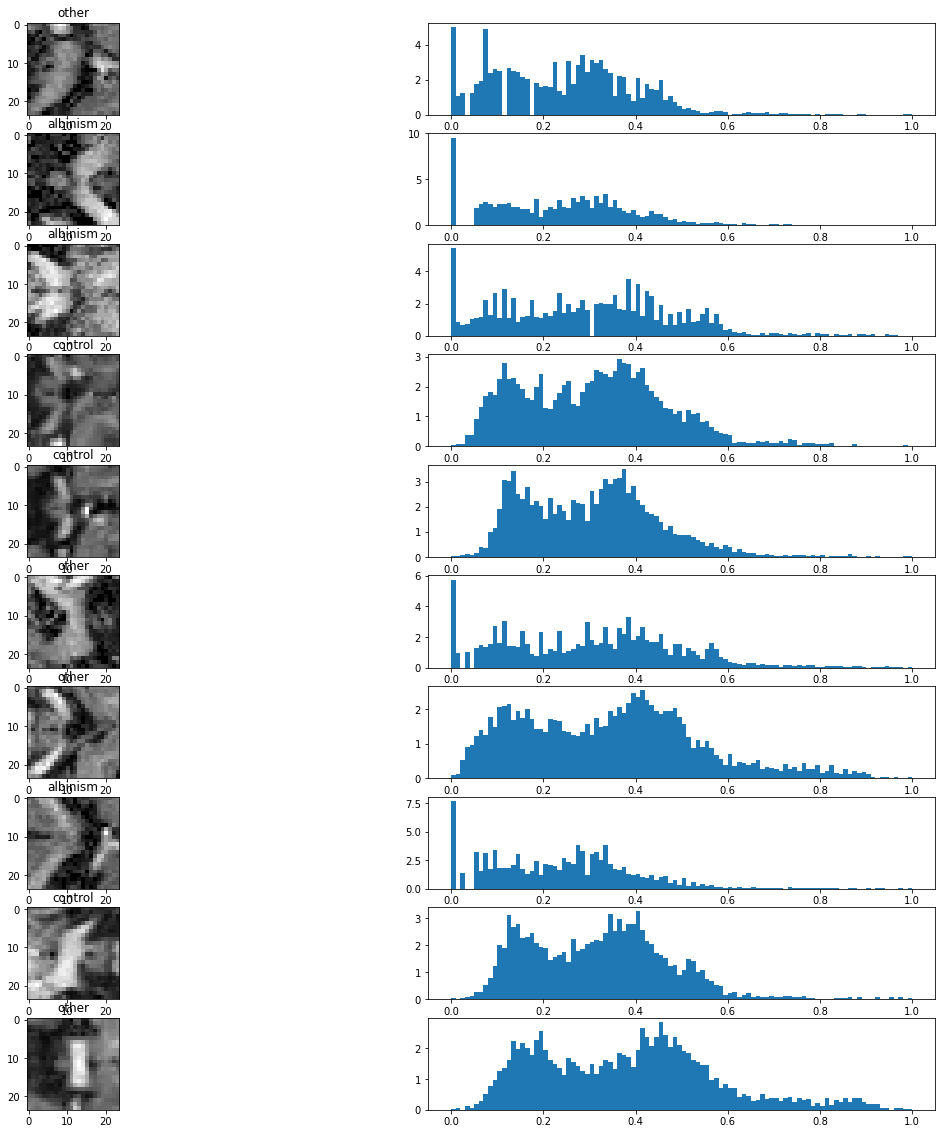

dev_train


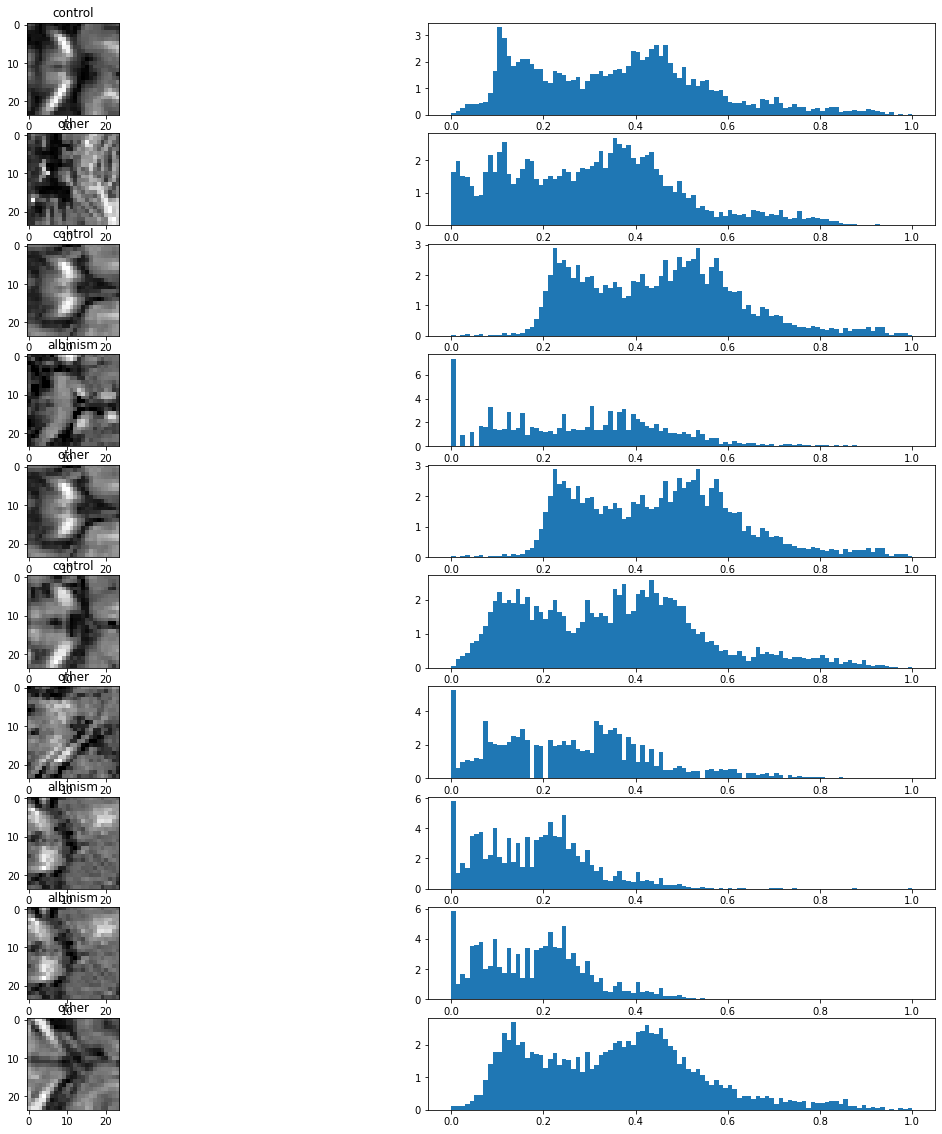

dev_test


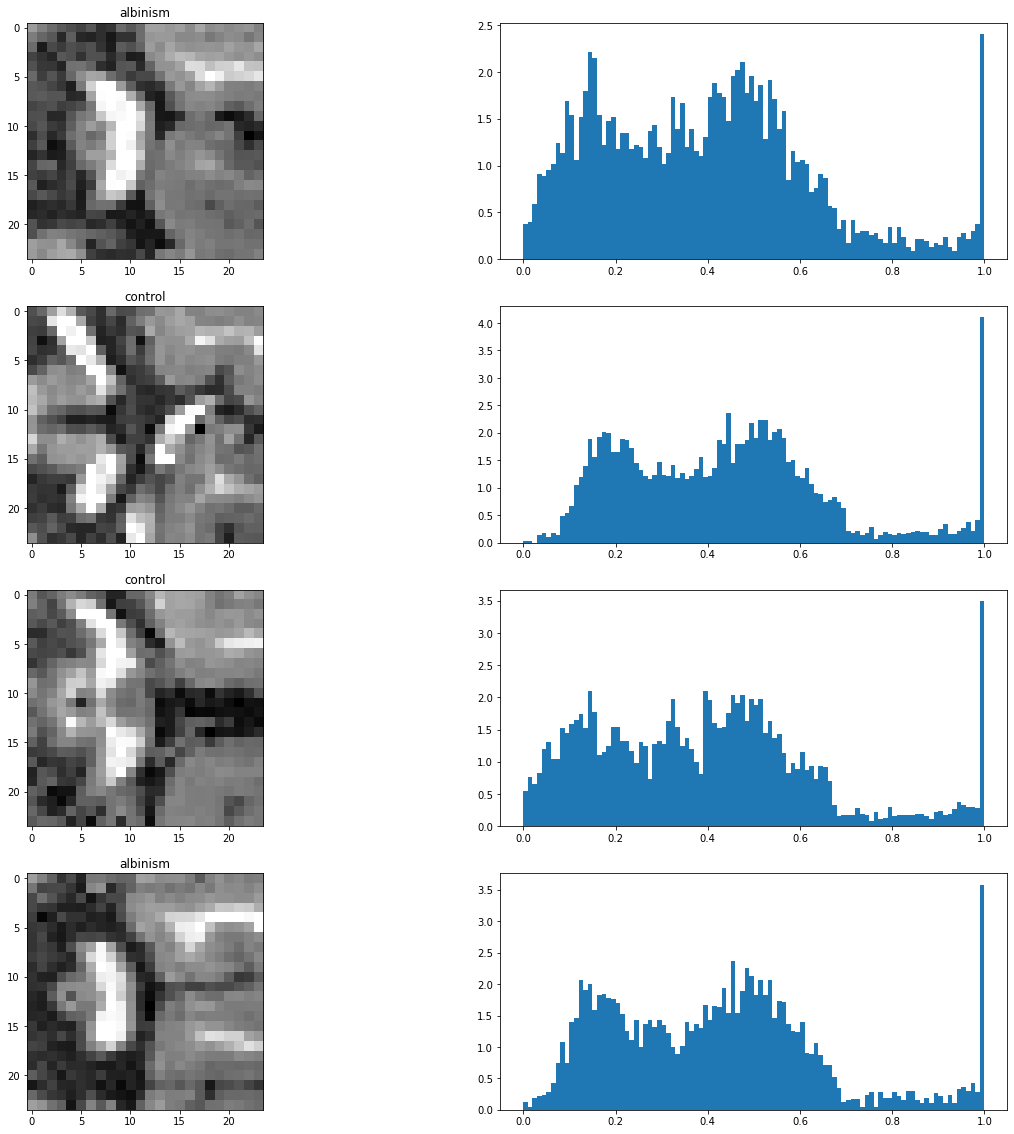

In [17]:
# Visualize results
classes=['control','albinism','other']

for group in ['train', 'dev_train', 'dev_test']:
    
    print(group)
    
    batch = next(enumerate(dataloaders_chiasm[group]))
    
    data = batch[1]['chiasm']['data']
    labels = batch[1]['label']
    
    inputs = data.cpu().numpy()

        
    fig = plt.figure(figsize=(20,20))
    
    for i in range(inputs.shape[0]):
        
        plt.subplot(inputs.shape[0],2,2*i+1)
        plt.imshow(inputs[i,0,:,:,5],cmap='gray');
        plt.title(classes[labels[i]])    
        plt.subplot(inputs.shape[0],2,2*i+2)
        plt.hist(inputs[i,0].reshape(-1),density=True, bins=100);
        plt.axis('on')
    
    plt.show()

# Network

In [18]:
# Cropped U-Net copied from Overfitting Model

class UNet(nn.Module):
    
    def __init__(self, in_channels=1, out_channels=1, init_features=10, scaling=2):
        super(UNet, self).__init__()
                
        # Encoding layers
        self.encoder1 = self.unet_block(in_channels, init_features, "enc1")
        self.pool1 = nn.AvgPool3d(kernel_size=2, stride=2, padding=0)
        self.encoder2 = self.unet_block(init_features, init_features*scaling, name='enc2')
        self.pool2 = nn.AvgPool3d(kernel_size=2, stride=2, padding=0)

        # Bottleneck layer
        self.bottleneck = self.unet_block(init_features*scaling, init_features*scaling**2, name='bottleneck')
        
        # Decoding layers (where merge with prevois encoding layers occurs)        
        self.upconv2 = nn.ConvTranspose3d(init_features*scaling**2, init_features*scaling, kernel_size=2, stride=2)
        self.decoder2 = self.unet_block(init_features*scaling, init_features*scaling, name='dec2')
                
        self.upconv1 = nn.ConvTranspose3d(init_features*scaling, init_features, kernel_size=2, stride=2)
        self.decoder1 = self.unet_block(init_features, init_features, name='dec1')
        
        # Final convolution - output equals number of output channels
        self.conv = nn.Conv3d(init_features, out_channels, kernel_size=1) 
        
    def forward(self,x):
        
        # Encoding
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool2(enc2))

        # Upconvolving, concatenating data from respective encoding phase and executing UNet block
        dec2 = self.upconv2(bottleneck)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = self.decoder1(dec1)
        
        out_conv = self.conv(dec1)
        
        return torch.sigmoid(out_conv)
    
    def unet_block(self, in_channels, features, name):
        
        return nn.Sequential(OrderedDict([(name+'conv1',nn.Conv3d(in_channels=in_channels, out_channels=features, kernel_size=3, padding=1, bias=False)),
                             (name+'bnorm1', nn.BatchNorm3d(num_features=features)),
                             (name+'relu1', nn.ReLU(inplace=True)),
                             (name+'conv2', nn.Conv3d(in_channels=features, out_channels=features, kernel_size=3, padding=1, bias=False)),
                             (name+'bnorm2', nn.BatchNorm3d(num_features=features)),
                             (name+'relu2', nn.ReLU(inplace=True))])
                            )

    def output_latent_representations(self,x):
        
        print(x.shape)

        # Encoding
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool2(enc2))
        
        print(bottleneck.shape)
        
        return bottleneck

In [19]:
class Classify_chiasm(nn.Module):
    
    def __init__(self, init_features, scaling, num_fc_layers, num_hidden_nodes, weights_path='../../1_Data/2_Trained_AE/'):
        super(Classify_chiasm, self).__init__()
        
        self.init_features = init_features
        self.scaling = scaling
        self.num_fc_layers = num_fc_layers
        self.num_hidden_nodes = num_hidden_nodes
        
        # Initialize the network_extracting_features and load its weights
        network_extracting_features = UNet(1,1,init_features,scaling)
        network_extracting_features.load_state_dict(torch.load(weights_path+'/'+str(init_features)+'_'+str(scaling)+'/optimal_weights'))
        
        child = network_extracting_features.children()
        
        # Copying the desired components (analysis stream) from network_extracting_features
        self.feature_extraction = nn.Sequential(*list(child)[:5])
        
        # Classification layers
        if self.num_fc_layers==0:
            self.classifier = nn.Linear(self.init_features*(self.scaling**2)*6*6*2,3)
        elif self.num_fc_layers==1:
            self.classifier = nn.Sequential(nn.Linear(self.init_features*(self.scaling**2)*6*6*2,self.num_hidden_nodes),nn.ReLU(),nn.Linear(self.num_hidden_nodes,3))
        
        # Placeholder for gradients
        self.gradients = None
    
    # Freeze all the layers apart from the classifying one
    def freeze_feature_extraction(self):
        
        counter = 0
        for layer in classifying_network.children():
            counter += 1
            if counter < 2:
                #print(layer)
                for param in layer.parameters():
                    param.requires_grad = False
            
    # Hook for the activations' gradients
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self,x):
        
        # To ensure that gradients will be tracked
        #x.requires_grad = True
        
        # Feature extraction
        x = self.feature_extraction(x)
        
        # Register the hook
        if self.train and x.requires_grad:
            h = x.register_hook(self.activations_hook)

        # Flatten the image
        #x = torch.flatten(x, start_dim=1)
        x = x.view((x.shape[0], -1))        

        # Classifying FC layer and activation function
        x = self.classifier(x)
        
        return torch.softmax(x, dim=1)

    # Output latent representations (or activations) of the last CNN layer
    def output_latent_representations(self,x):        
        return self.feature_extraction(x)     
    
    # Output gradient
    def output_activation_gradient(self):
        return self.gradients
    
    def gradcam_backup(self, x):
        
        # Calculate prediction
        pred = self.forward(x)
        
        # Get the gradient from the prediction
        pred.backward()
         
        # Extract the gradients from final layer extracting features
        gradients = self.output_activation_gradient()
        print(gradients.shape)
        
        # Pool the gradients
        pooled_gradients = torch.mean(gradients, dim=[0,2,3,4])
        
        # Extract activations
        activations = self.output_latent_representations(x).detach()
        
        # Weight activations by the gradients
        activations[:, i, :, :, :] *= pooled_gradients[i]
        
        # Average the channels of the activations
        heatmap = torch.mean(activations, dim=1).squeeze()
        
        heatmap = np.maximum(heatmap, 0)
        
        heatmap /= torch.max(heatmap)
        
        return heatmap    
        
    def gradcam(self, x, class_id):

        # Calculate prediction
        pred = self.forward(x)

        # Get the gradient from the prediction
        pred[:,class_id].backward()

        # Extract the gradients from final layer extracting features
        gradients = self.output_activation_gradient()
        print(gradients.shape)

        # Pool the gradients
        pooled_gradients = torch.mean(gradients, dim=[0,2,3,4])

        # Extract activations
        activations = self.output_latent_representations(x).detach()

        # Weight activations by the gradients
        for i in range(self.init_features * self.scaling**2):
            activations[:, i, :, :, :] *= pooled_gradients[i]

        # Average the channels of the activations
        heatmap = torch.mean(activations, dim=1).squeeze()

        heatmap = np.maximum(heatmap, 0)

        heatmap /= torch.max(heatmap)

        return heatmap    

In [20]:
   '''
    def gradcam(self, x, class_id):
        
        pred = self.forward(x)
        
        pred[:, class_id].backward()
        
        gradients = self.get_activations_gradient()
        
        pooled_gradients = torch.mean(gradients, dim=[0,2,3])
        
        activations = self.get_activations(x).detach()
        
        for i in range(512):
            activations[:, i, :, :] *= pooled_gradients[i]
            
        heatmap = torch.mean(activations, dim=1).squeeze()
        
        heatmap = np.maximum(heatmap, 0)
        
        heatmap /= torch.max(heatmap)
        
        return heatmap
        '''

'\n def gradcam(self, x, class_id):\n     \n     pred = self.forward(x)\n     \n     pred[:, class_id].backward()\n     \n     gradients = self.get_activations_gradient()\n     \n     pooled_gradients = torch.mean(gradients, dim=[0,2,3])\n     \n     activations = self.get_activations(x).detach()\n     \n     for i in range(512):\n         activations[:, i, :, :] *= pooled_gradients[i]\n         \n     heatmap = torch.mean(activations, dim=1).squeeze()\n     \n     heatmap = np.maximum(heatmap, 0)\n     \n     heatmap /= torch.max(heatmap)\n     \n     return heatmap\n     '

# Training

In [21]:
# Try setting CUDA if possible
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu") 
    
print(device)

cuda


In [22]:
# Criterion
criterion = nn.NLLLoss()

In [23]:
# Function returning trained model
def train_network(n_epochs, dataloaders, model, optimizer, criterion, device, save_path):
    
    track_train_loss = []
    track_dev_train_loss = []
    track_dev_test_loss = []
    
    track_train_acc = []
    track_dev_train_acc = []
    track_dev_test_acc = []
    
    valid_loss_min = np.Inf
    
    model.to(device)
        
    for epoch in tqdm(range(1, n_epochs+1)):
        
        # Initialize loss monitoring variables
        train_loss = 0.0
        dev_train_loss = 0.0
        dev_test_loss = 0.0
                
        # Training
        model.train()
        
        acc_targets=[]
        acc_predictions=[]
        
        for batch in dataloaders['train']:
            
            data = batch['chiasm']['data'].to(device)
            data.requires_grad = True
            
            optimizer.zero_grad()
            
            output=model(data)
            
            loss = criterion(output, batch['label'].to(device))
            loss.backward()
            
            optimizer.step()
            
            train_loss+= (loss.item()*len(batch['label']))
            
            acc_targets+=batch['label'][:].numpy().tolist()
            acc_predictions+=output.argmax(dim=1).cpu().numpy().tolist()
            
        track_train_loss.append(train_loss/len(concatenated_datasets['train']))        
        track_train_acc.append(accuracy_score(acc_targets, acc_predictions)) 
            
        # Validation on two datasets
        model.eval()
        
        acc_targets=[]
        acc_predictions=[]
        
        for batch in dataloaders['dev_train']:
            
            data = batch['chiasm']['data'].to(device)
            data.requires_grad = True
            
            with torch.no_grad():
                
                output = model(data)
                loss = criterion(output, batch['label'].to(device))
                
                dev_train_loss+= (loss.item()*len(batch['label']))
                
                acc_targets+=batch['label'][:].numpy().tolist()
                acc_predictions+=output.argmax(dim=1).cpu().numpy().tolist()
                
        track_dev_train_loss.append(dev_train_loss/len(concatenated_datasets['dev_train']))
        track_dev_train_acc.append(accuracy_score(acc_targets, acc_predictions)) 
        
        acc_targets=[]
        acc_predictions=[]
        
        for batch in dataloaders['dev_test']:
            
            data = batch['chiasm']['data'].to(device)
            data.requires_grad = True
            
            with torch.no_grad():
                
                output = model(data)
                loss = criterion(output, batch['label'].to(device))
                
                dev_test_loss+= (loss.item()*len(batch['label']))
                
                acc_targets+=batch['label'][:].numpy().tolist()
                acc_predictions+=output.argmax(dim=1).cpu().numpy().tolist()
                
        track_dev_test_loss.append(dev_test_loss/len(concatenated_datasets['dev_test']))
        track_dev_test_acc.append(accuracy_score(acc_targets, acc_predictions)) 
        
        if epoch%500 ==0:
            print('END OF EPOCH: {} \n Training loss per image: {:.6f}\n Training_dev loss per image: {:.6f}\n Test_dev loss per image: {:.6f}'.format(epoch, train_loss/len(concatenated_datasets['train']),dev_train_loss/len(concatenated_datasets['dev_train']),dev_test_loss/len(concatenated_datasets['dev_test'])))
            
        ## Save the model if reached min validation loss and save the number of epoch               
        if dev_train_loss < valid_loss_min:
            valid_loss_min = dev_train_loss
            torch.save(model.state_dict(),save_path+'optimal_weights')
        
            with open(save_path+'number_epochs.txt','w') as f:
                print('Epoch:', str(epoch), file=f)  
                                
    # return trained model
    return track_train_loss, track_dev_train_loss, track_dev_test_loss, track_train_acc, track_dev_train_acc, track_dev_test_acc

In [24]:
model_parameters=[[8,2],[32,1]]#
num_of_fc_layers=[0,1]
num_of_hidden_nodes=[256,64,4]
learning_rates = [0.002, 0.0002,0.00002,0.000002]

n_epochs=2500

folder='../../1_Data/3_Trained_classifier/'

for parameters in model_parameters:
    for fc_layer in num_of_fc_layers:
        for hidden_nodes in num_of_hidden_nodes:
            for learning_rate in learning_rates:
                
                # Initialize the proper model
                classifying_network = Classify_chiasm(parameters[0],parameters[1], fc_layer, hidden_nodes)
                classifying_network.freeze_feature_extraction()

                # Optimizer    
                optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, classifying_network.parameters()), lr=learning_rate) # previous best 0.000002
                #optimizer = torch.optim.Adam(params=classifying_network.parameters(), lr=0.00005)

                # Create output folder
                data_folder = folder+'/'+str(parameters[0])+'_'+str(parameters[1])+'_'+str(fc_layer)+'_'+str(hidden_nodes)+'_'+str(learning_rate)+'/'
                os.makedirs(data_folder, exist_ok=True)

                # Train & save weights
                train_loss, dev_train_loss, dev_test_loss, train_acc, dev_train_acc, dev_test_acc = train_network(n_epochs, dataloaders_chiasm, classifying_network, optimizer, criterion, device, data_folder)

                # Save losses
                with open(data_folder+'train_loss.pkl', 'wb') as f:
                    pickle.dump(train_loss, f)

                with open(data_folder+'dev_train_loss.pkl', 'wb') as f:
                    pickle.dump(dev_train_loss, f)

                with open(data_folder+'dev_test_loss.pkl', 'wb') as f:
                    pickle.dump(dev_test_loss, f)

                with open(data_folder+'train_acc.pkl', 'wb') as f:
                    pickle.dump(train_acc, f)

                with open(data_folder+'dev_train_acc.pkl', 'wb') as f:
                    pickle.dump(dev_train_acc, f)

                with open(data_folder+'dev_test_acc.pkl', 'wb') as f:
                    pickle.dump(dev_test_acc, f)

100%|██████████| 2500/2500 [42:34<00:00,  1.02s/it]


# Secondary functions

In [ ]:
# Count layers where require_grad = True
counter = 0
for layer in classifying_network.children():
    for param in layer.parameters():
        if param.requires_grad == True:
            counter += 1

print(counter)
            

In [ ]:
# Freeze the network
classifying_network.freeze_feature_extraction()

In [ ]:
# Count layers where require_grad = True
counter = 0
for layer in classifying_network.children():
    for param in layer.parameters():
        if param.requires_grad == True:
            counter += 1

print(counter)
            